# Exercises for 2021-04-01

In [2]:
using LinearAlgebra
using Plots

## Constructing cardinals
## TODO
(3 points): Consider approximating functions on $[-1, 1]$ by functions in the space spanned by $\cos(x)$, $\sin(x)$, $1$, $x$, and $x^2$.  Compute and plot the cardinal functions (aka the Lagrange functions) for the interpolation points
$1, 1/2, 0, -1/2, -1$.

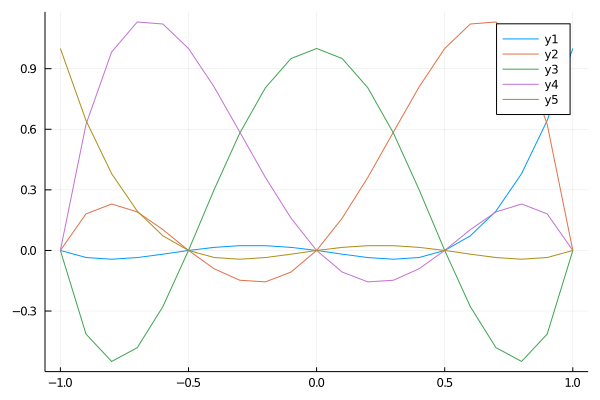

In [3]:
A = [ 1  1     1     cos(1)    sin(1);
      1  0.5   0.25  cos(0.5)  sin(0.5);
      1  0     0     cos(0)    sin(0);
      1  -0.5  0.25  cos(-0.5) sin(-0.5);
      1  -1    1     cos(-1)   sin(-1)]

e  = Matrix{Int}(I, 5,5)
C = [A\e[i,:] for i=1:5]
xx = -1.0:0.1:1.0
L(x,c) = c[1] + c[2]x + c[3]x^2 + c[4]cos(x) + c[5]sin(x)
fig = plot()
for c in C
    plot!(fig, xx, x -> L(x,c))
end
fig

## TODO
(1 point): Estimate the Lebesgue constant for this space and interpolation points.

In [4]:
# maximum over the interval [-1,1] of the sum of the absolute values of the Lagrange functions
λ(x) = sum([abs(L(x,c)) for c in C])
Λ = maximum([λ(x) for x in xx])

2.1858439525218865

## Active subspaces

Consider the following function, which returns $f(v)$ and $\nabla f(v)$.

In [5]:
# Returns f(v) and ∇f(v) for v in R^101
function ground_state(v)
  A = SymTridiagonal(-2*ones(101) + abs.(-50:50) + v, ones(100))
  λ = eigmin(A)
  ψ = eigvecs(A, [λ])[:,1]
  return λ, ψ.^2
end

ground_state (generic function with 1 method)

Whenever computing an analytic gradient, it is worthwhile to do a sanity check to make sure that the directional derivatives match.  It turns out that a random direction or two is a good enough check most of the time.

In [6]:
vrand = 2*rand(101).-1
dvrand = 2*rand(101).-1
fv, ∇fv = ground_state(vrand)
fv2, ∇fv2 = ground_state(vrand + 1e-3*dvrand)
println("Finite difference: $((fv2-fv)/1e-3); analytical: $(dvrand'*∇fv)")

Finite difference: -0.2840508810511011; analytical: -0.28398456689421603


## TODO

(1 point): Explain what the finite difference check is doing.

The finite difference check $((fv2-fv)/1e^{-3})$ is calculating the derivative by finite difference approximation using the function values returned by the function "ground_state"; this approximation is compared to the derivative as given by the function "ground_state."

## TODO
(3 points): Apply the active subspace approach to the following problem where each $v_i$ is between $-1$ and $1$.  Use 200 samples drawn uniformly in the domain.  If we discard all singular values less than 5\% of the largest, how many do we keep?  Plot the three directions; what do you observe?

We keep 3 singular values

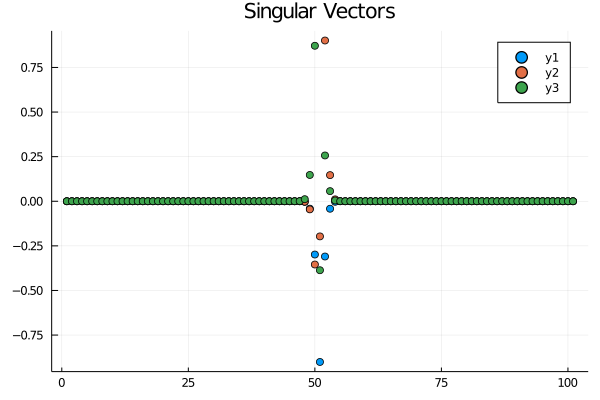

In [39]:
using Random
samps = [2*rand(101).-1 for x in 1:200]
S     = [ground_state(s) for s in samps]
C     = [S[i][2]*S[i][2]' for i in 1:size(S)[1]]

n     = size(C[1])
D     = zeros(n)
for i = 1:size(C)[1]
    D .+= C[i] 
end
D = D./200

U,Σ,Vt = svd(D)
acc = 0
for i = 1:size(Σ)[1]
    if (sqrt(Σ[i]) >= 0.05*sqrt(Σ[1]))
        acc += 1 
    end
end
print("We keep $acc singular values")
p= scatter(U[:,1],seriestype = :scatter)
q= scatter!(p,U[:,2],seriestype = :scatter)
scatter!(q,U[:,3],seriestype = :scatter, title = "Singular Vectors")

## POD and EIM

Consider the following function (the Rosenbrock function) on $[-2, 2] \times [-1, 3]$.

In [41]:
rosen(x,y) = (1-x)^2 + 100*(y-x^2)^2
rosen3(x,y,z) = 100*(y-x^2)^2 + 100*(z-y^2)^2 + (1-x)^2 + (1-y)^2

rosen3 (generic function with 1 method)

Now we evaluate the function on a regular mesh and plot.

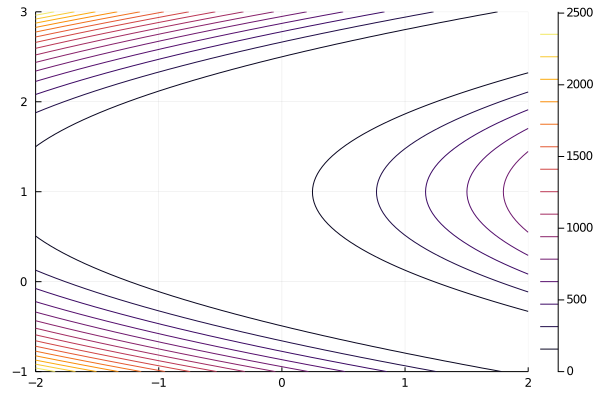

In [42]:
xmesh = range(-2,2, length=101)
ymesh = range(-1,3, length=101)
F = [rosen(x,y) for x in xmesh, y in ymesh]
plot(xmesh, ymesh, F, st = [:contourf])

## TODO
(2 points): Run the SVD on $F$.  What is the rank?  Explain why this makes sense.

In [44]:
U,S,Vt = svd(F)
r = rank(diagm(S))
print("F is rank $r, having 3 nonzero singular values")

F is rank 3, having 3 nonzero singular values

## TODO
(3 points): Implement and run the empirical interpolation method (three steps should be enough).  What three interpolation points are selected?

In [55]:
function eim(u)
    n,m = size(u)
    U   = zeros(n,m)
    ρ   = zeros(m)
    e   = Matrix{Int}(I, n,n)
    
    ind = argmax(abs.(u[:,1]))
    ρ[1]     = ind
    P        = e[:,ind]
    U[:,1]   = u[:,1]
    for l = 2:m 
        u_l    = u[:,l]
        c      = (P'*U)\(P'*u_l)
        r      = u_l - U*c
        ind_l  = argmax(abs.(r))
        U[:,l] = u_l 
        P      = cat(dims=2,P,e[:,ind_l])
        ρ[l]   = ind_l
    end
    return ρ
end
ρ, ρ2, ρ3 = eim(U[:,1:3])
print("Indices  $ρ1, $ρ2, $ρ3 are selected")

Indices  1.0, 51.0, 86.0 are selected